## Temporally Extended Successor Representations

### Imports 

In [4]:

import utils 
import numpy as np
import matplotlib.pyplot as plt
import itertools

from collections import defaultdict

%matplotlib inline


### (Hyper)parameters

In [5]:
GAMMA = 0.99
MAX_SKIP = 7
EPS = 0.05
ALPHA = 0.5
N_MACRO = 3
ENV_NAME = "four_way_junction" # four_rooms, junction_hard, open_field_10, open_field 50


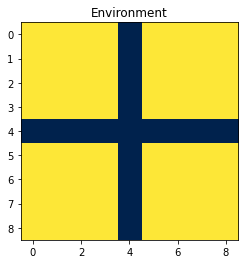

In [6]:
Ts, env = utils.make_transition_functions(ENV_NAME)
dims = utils.get_dims(env)
utils.plot_env(env)

### Vanilla successor representation
$$\mathbf{M}^{\pi}(s, s') = (I - \gamma T^{\pi})^{-1}$$
$$\pi = \text{uniform random} $$

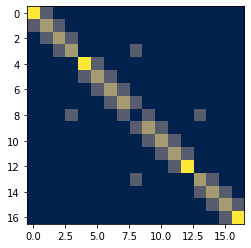

[16.14688601 12.7588814   9.88638716  7.4133429   3.66679964  3.81495316
  4.1172462   4.58589263  5.23982764  4.58589263  4.1172462   3.81495316
  3.66679964  4.58589263  4.1172462   3.81495316  3.66679964]


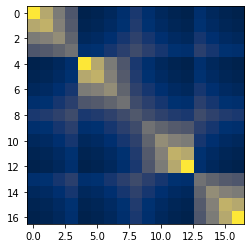

In [7]:
M_uniform = utils.compute_random_walk_SR(Ts, gamma = GAMMA)
print(M_uniform[0, :])
utils.plot_SR(M_uniform)


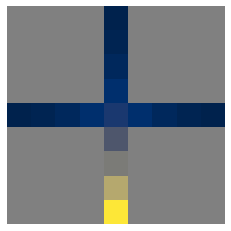

In [8]:
utils.plot_SR_column(M_uniform, env, s= 16, dims = dims, title = "", show = True, save = False)

### Online Macro Action Discovery - Multiple Macro Actions


Here we will try macro action discovery over a set of potential macro actions. We will try this in the simplest way possible: using a precomputed baseline SR; fixing the starting state, and randomly sampling the macro actions. We will compute their tSRs, and use the difference between the baseline and tSR as a reward in our abstract MDP.  

In this highly simplifed setting, we hope to recover three macro actions: one for each end of three reachable corridors. We will help even more by setting the length of our macro actions to match the length of the desired trajectories. 

#### Random Walk

In [27]:
# on policy SARSA style TD update rules for random walk

def train_random_walk_multiple_macro(n_traj = 100000, macro_length = 8, n_macro = 3):
    # fixed starting state
    s = 16
    
    action_map = {0: "UP", 1: "RIGHT", 2: "DOWN", 3: "LEFT"}
    
    # define abstract Q values and SRs for macro actions
    macro_action_Q = {i: {j: np.zeros(len(action_map.keys())) for j in range(macro_length)} \
                       for i in range(n_macro)} 
    macro_action_M = {i: defaultdict(lambda: np.zeros(dims["states"])) for i in range(n_macro)}
                                                                   
    # pre compute a baseline SR
    M_baseline =  utils.compute_random_walk_SR(Ts, gamma = GAMMA)

    # action space is only the macro actions
                    
    for i in range(n_traj):
                                                                   
        mac = np.random.randint(n_macro)
        macro_reward = np.zeros(dims["states"])
        # store rewards along the subtrajectory to update at the end so we know what actions we are taking
        abstract_rewards = np.zeros(macro_length)
        macro_rewards = np.zeros([macro_length, dims["states"]])

        states_seen = [s]
        actions_taken = []
        curr_Q_abst = macro_action_Q[mac]
        curr_M_macro = macro_action_M[mac]
        for t in range(macro_length):
            q_t = curr_Q_abst[t]
            # awkward syntax for tie breaks
            a = np.random.choice(np.where(q_t == q_t.max())[0])
            # eps greedy - probably don't need it?
            if np.random.rand(1) < EPS:
                a = np.random.randint(4)
            s_vector = Ts[action_map[a]][s]
            s_ = int(np.where(s_vector == 1)[0])
            states_seen.append(s_)
            actions_taken.append(a)
            s = s_
        # now we have the sequence of actions and states, we can compute the abstract rewards

        # TODO update tSR before or after abstract rewards are computed? 
        
        # TODO do not loop over s, loop over s' 
        abstract_reward = [np.sum(curr_M_macro[(states_seen[0])][_s] - M_baseline[states_seen[0], _s]) for _s, a in zip(states_seen[1:], actions_taken)]
        #print("macro", curr_M_macro[(states_seen[0])][s])
        #print("baseline", M_baseline[states_seen[0], s])
        # choose last action randomly - could take the expectation over the last SR instead
        a_ = np.random.randint(4)
        t = len(actions_taken) - 1
        # final abstract state is always a terminal state - has zero value
        q_tp1 = np.zeros(len(action_map.keys()))
        # TODO seeing as we are doing this reverse loop, we could compute n-step returns
        macro_reward = np.zeros(dims['states'])
        
        for a in reversed(actions_taken):
            #s_vector = np.eye(dims["states"])[s_]
            #macro_reward += s_vector + GAMMA * macro_reward
            #M_macro[(s, a)] += ALPHA * (sr_target - M_macro[(s,a)])

            q_t = curr_Q_abst[t]
            target = abstract_reward[t] + GAMMA * q_tp1[a_]
            q_t[a] += ALPHA * (target - q_t[a])

            a_ = a
            q_tp1 = q_t
            t+=-1
            
        #print("start loop")
        for t, s_ in enumerate(states_seen[1:]):
            s_vector = np.eye(dims["states"])[s_]
            macro_reward += (GAMMA**t)*s_vector
            
        a_ = np.random.randint(4)
        #print(macro_reward)
        sr_target = macro_reward + (GAMMA**(len(actions_taken)))*curr_M_macro[(states_seen[-1])]
        curr_M_macro[(states_seen[0])] += ALPHA * (sr_target - curr_M_macro[(states_seen[0])])
        # make sure last action matches for next step
        a = actions_taken[-1]
        
        # reset to starting state
        s = 16
                                                                   
                                                                   
    return macro_action_Q, macro_action_M

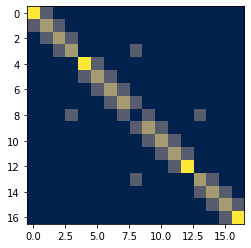

In [28]:
macro_action_Q, macro_action_M,  = train_random_walk_multiple_macro(n_macro = N_MACRO)